<a href="https://colab.research.google.com/github/egamix/scratch/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Automatically reload imported modules that are changed outside this notebook
%load_ext autoreload
%autoreload 2

# More pixels in figures
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.dpi"] = 200

# Init PRNG with fixed seed for reproducibility
import numpy as np
np_rng = np.random.default_rng(1)

import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

tf.random.set_seed(np_rng.integers(0, tf.int64.max))

# try:
#   tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
#   print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
# except ValueError:
#   raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)
# tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Found GPU at: /device:GPU:0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import sys
sys.path.insert(0,'/content/drive/My Drive/lidbox-master')

# Audio augmentation by random speed changes and random filtering

**2020-11-10**


This example expands `common-voice-small`, in which we talked about different ways of augmenting the dataset.
Instead of simply copying samples, we can resample them randomly to make them a bit [faster or slower](https://www.isca-speech.org/archive/interspeech_2015/i15_3586.html).
In addition, by applying random [finite impulse response](https://en.wikipedia.org/wiki/Finite_impulse_response) (FIR) filters on the signals, we can try to [simulate microphone differences](https://www.isca-speech.org/archive/Interspeech_2018/abstracts/1047.html).
We'll apply these two augmentation techniques in this example and see if it is possible to improve on our previous results.

`tf.data.Dataset` makes it easy to cache all raw audio samples into a single file, from which we can reload the whole dataset at each epoch.
This means that we can reapply both random augmentation techniques at every epoch, hopefully with different output at each epoch.

## Data

This example uses the same data as in the `common-voice-small` example.

In [4]:
import urllib.parse
from IPython.display import display, Markdown


languages = """
    id
    th
    vi
""".split()

languages = sorted(l.strip() for l in languages)

display(Markdown("### Languages"))
display(Markdown('\n'.join("* `{}`".format(l) for l in languages)))

bcp47_validator_url = 'https://schneegans.de/lv/?tags='
display(Markdown("See [this tool]({}) for a description of the BCP-47 language codes."
                 .format(bcp47_validator_url + urllib.parse.quote('\n'.join(languages)))))

### Languages

* `id`
* `th`
* `vi`

See [this tool](https://schneegans.de/lv/?tags=id%0Ath%0Avi) for a description of the BCP-47 language codes.

## Loading the metadata

In [5]:
import os

!mkdir data
workdir = "/data/"
datadir = "/content/drive/MyDrive/lidbox-master/cv-corpus"

print("work dir:", workdir)
print("data source dir:", datadir)
print()

os.makedirs(workdir, exist_ok=True)
assert os.path.isdir(datadir), datadir + " does not exist"

dirs = sorted((f for f in os.scandir(datadir) if f.is_dir()), key=lambda f: f.name)

print(datadir)
for d in dirs:
    if d.name in languages:
        print(' ', d.name)
        for f in os.scandir(d):
            print('   ', f.name)

missing_languages = set(languages) - set(d.name for d in dirs)
assert missing_languages == set(), "missing languages: {}".format(missing_languages)

work dir: /data/
data source dir: /content/drive/MyDrive/lidbox-master/cv-corpus

/content/drive/MyDrive/lidbox-master/cv-corpus
  id
    test.tsv
    invalidated.tsv
    train.tsv
    dev.tsv
    other.tsv
    validated.tsv
    reported.tsv
    clips
  th
    validated.tsv
    test.tsv
    dev.tsv
    other.tsv
    invalidated.tsv
    train.tsv
    reported.tsv
    clips
  vi
    other.tsv
    dev.tsv
    validated.tsv
    test.tsv
    invalidated.tsv
    train.tsv
    reported.tsv
    clips


In [ ]:
!ls

data  drive  sample_data


In [6]:
!pip install miniaudio

     |████████████████████████████████| 522kB 8.5MB/s 
  Created wheel for miniaudio: filename=miniaudio-1.41-cp36-cp36m-linux_x86_64.whl size=512552 sha256=984ac28cfc8d258c8e9e7750875902f7da0982b202966e590feb6cab77001fe5
  Stored in directory: /root/.cache/pip/wheels/3a/81/ce/f1879cec928935294501ebb0eea30dfd5b792447161e40668b
Successfully built miniaudio


In [7]:
from lidbox.meta import common_voice, generate_label2target


meta = common_voice.load_all(datadir, languages)
meta, lang2target = generate_label2target(meta)

print("lang2target")
for l, t in lang2target.items():
    print("  {}: {}".format(l, t))

for split in meta.split.unique():
    display(Markdown("### " + split))
    display(meta[meta["split"]==split])

lang2target
  id: 0
  th: 1
  vi: 2


### test

,client_id,path,sentence,label,split,target
id,,,,,,
common_voice_id_19051299,id_72d3fc6643fbf91a40dcfe12bca817bee42ac724706...,/content/drive/MyDrive/lidbox-master/cv-corpus...,John mewakili kelasnya di perlombaan renang.,id,test,0
common_voice_id_19051301,id_72d3fc6643fbf91a40dcfe12bca817bee42ac724706...,/content/drive/MyDrive/lidbox-master/cv-corpus...,Seperti apa wawancara anda?,id,test,0
common_voice_id_19051302,id_72d3fc6643fbf91a40dcfe12bca817bee42ac724706...,/content/drive/MyDrive/lidbox-master/cv-corpus...,Dia meninggal dunia kemarin siang.,id,test,0
common_voice_id_19051304,id_72d3fc6643fbf91a40dcfe12bca817bee42ac724706...,/content/drive/MyDrive/lidbox-master/cv-corpus...,Apakah ini sangat sakit?,id,test,0
common_voice_id_19051308,id_72d3fc6643fbf91a40dcfe12bca817bee42ac724706...,/content/drive/MyDrive/lidbox-master/cv-corpus...,"Seperti ayah, seperti anak.",id,test,0
...,...,...,...,...,...,...
common_voice_vi_23852465,vi_7fe9e42c31db591e3f2591ce9091ee1d1da77d18c5f...,/content/drive/MyDrive/lidbox-master/cv-corpus...,Giọng của cô bé Thu Ngân đang trả lại Trinh ti...,vi,test,2
common_voice_vi_23852469,vi_7fe9e42c31db591e3f2591ce9091ee1d1da77d18c5f...,/content/drive/MyDrive/lidbox-master/cv-corpus...,Trộm không thể vào,vi,test,2
common_voice_vi_23852470,vi_7fe9e42c31db591e3f2591ce9091ee1d1da77d18c5f...,/content/drive/MyDrive/lidbox-master/cv-corpus...,Chỉ còn nồng hơi thở những vần thơ,vi,test,2


### dev

,client_id,path,sentence,label,split,target
id,,,,,,
common_voice_id_19056654,id_25dff0831f072ad7bc1a419bab0ed27094030707377...,/content/drive/MyDrive/lidbox-master/cv-corpus...,Aku ingin mati bersama Getter Jaani.,id,dev,0
common_voice_id_19056662,id_25dff0831f072ad7bc1a419bab0ed27094030707377...,/content/drive/MyDrive/lidbox-master/cv-corpus...,Aku harus menyelesaikan pekerjaan itu pada tan...,id,dev,0
common_voice_id_19056665,id_25dff0831f072ad7bc1a419bab0ed27094030707377...,/content/drive/MyDrive/lidbox-master/cv-corpus...,"Mudah didapat, mudah hilang.",id,dev,0
common_voice_id_19056666,id_25dff0831f072ad7bc1a419bab0ed27094030707377...,/content/drive/MyDrive/lidbox-master/cv-corpus...,Dia kurang cocok menjadi guru.,id,dev,0
common_voice_id_19062330,id_25dff0831f072ad7bc1a419bab0ed27094030707377...,/content/drive/MyDrive/lidbox-master/cv-corpus...,Di sana ada guru.,id,dev,0
...,...,...,...,...,...,...
common_voice_vi_23926775,vi_c14ad590de005be3a512e187900c5ad5c76921cf188...,/content/drive/MyDrive/lidbox-master/cv-corpus...,Khiến cho Tinh nổi da gà,vi,dev,2
common_voice_vi_23926782,vi_c14ad590de005be3a512e187900c5ad5c76921cf188...,/content/drive/MyDrive/lidbox-master/cv-corpus...,Dạ Cháu không có ý đó cháu chỉ là,vi,dev,2
common_voice_vi_23926854,vi_c14ad590de005be3a512e187900c5ad5c76921cf188...,/content/drive/MyDrive/lidbox-master/cv-corpus...,mẹ thảo đáp,vi,dev,2


### train

,client_id,path,sentence,label,split,target
id,,,,,,
common_voice_id_19059295,id_8eb6a0f8aa447f1ea0fc2c8c57f6b88bb6027c5368e...,/content/drive/MyDrive/lidbox-master/cv-corpus...,"Jika Tom lebih dewasa, dia akan mengerti.",id,train,0
common_voice_id_19059296,id_8eb6a0f8aa447f1ea0fc2c8c57f6b88bb6027c5368e...,/content/drive/MyDrive/lidbox-master/cv-corpus...,Apa yang sedang kamu lihat?,id,train,0
common_voice_id_19059312,id_8eb6a0f8aa447f1ea0fc2c8c57f6b88bb6027c5368e...,/content/drive/MyDrive/lidbox-master/cv-corpus...,Napoleon Bonaparte lahir di Korsika.,id,train,0
common_voice_id_19059314,id_8eb6a0f8aa447f1ea0fc2c8c57f6b88bb6027c5368e...,/content/drive/MyDrive/lidbox-master/cv-corpus...,Saya mendorong Tom kedalam air.,id,train,0
common_voice_id_19059315,id_8eb6a0f8aa447f1ea0fc2c8c57f6b88bb6027c5368e...,/content/drive/MyDrive/lidbox-master/cv-corpus...,Dia tetap tidak mau mengakui kesalahannya.,id,train,0
...,...,...,...,...,...,...
common_voice_vi_23848895,vi_c44e0fee41f88045a040f1ffc8930be3c2a1bcc6f19...,/content/drive/MyDrive/lidbox-master/cv-corpus...,Mùa Thu về ngang phố,vi,train,2
common_voice_vi_23848896,vi_c44e0fee41f88045a040f1ffc8930be3c2a1bcc6f19...,/content/drive/MyDrive/lidbox-master/cv-corpus...,Quan trọng hơn,vi,train,2
common_voice_vi_23848897,vi_c44e0fee41f88045a040f1ffc8930be3c2a1bcc6f19...,/content/drive/MyDrive/lidbox-master/cv-corpus...,Đừng có sợ tao không có làm hại mày đâu,vi,train,2


### Checking the metadata is valid

In [8]:
from lidbox.meta import verify_integrity


print("size of all metadata", meta.shape)
meta = meta.dropna()
print("after dropping NaN rows", meta.shape)

print("verifying integrity")
verify_integrity(meta)
print("ok")

size of all metadata (13293, 6)
2020-12-20 14:16:25.565 I numexpr.utils: NumExpr defaulting to 2 threads.
after dropping NaN rows (13293, 6)
verifying integrity
ok


## Balancing the language distribution

We'll repeat the same random oversampling by audio sample length procedure as we did in `common-voice-small`.
This time, we add a flag `is_copy == True` to each oversampled copy, which allows us to easily filter all copies when we do random speed changes on the audio signals.

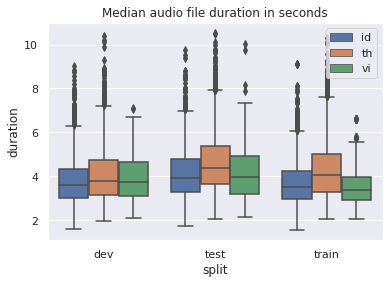

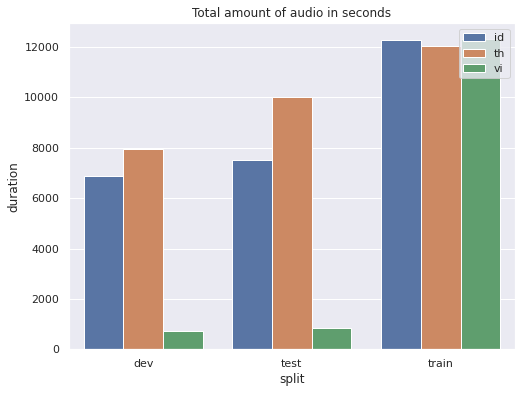

### test

,client_id,path,sentence,label,split,target,duration,is_copy
id,,,,,,,,
common_voice_id_19051299,id_72d3fc6643fbf91a40dcfe12bca817bee42ac724706...,/content/drive/MyDrive/lidbox-master/cv-corpus...,John mewakili kelasnya di perlombaan renang.,id,test,0,5.616,False
common_voice_id_19051301,id_72d3fc6643fbf91a40dcfe12bca817bee42ac724706...,/content/drive/MyDrive/lidbox-master/cv-corpus...,Seperti apa wawancara anda?,id,test,0,3.936,False
common_voice_id_19051302,id_72d3fc6643fbf91a40dcfe12bca817bee42ac724706...,/content/drive/MyDrive/lidbox-master/cv-corpus...,Dia meninggal dunia kemarin siang.,id,test,0,4.296,False
common_voice_id_19051304,id_72d3fc6643fbf91a40dcfe12bca817bee42ac724706...,/content/drive/MyDrive/lidbox-master/cv-corpus...,Apakah ini sangat sakit?,id,test,0,3.144,False
common_voice_id_19051308,id_72d3fc6643fbf91a40dcfe12bca817bee42ac724706...,/content/drive/MyDrive/lidbox-master/cv-corpus...,"Seperti ayah, seperti anak.",id,test,0,2.856,False
...,...,...,...,...,...,...,...,...
common_voice_vi_23852465,vi_7fe9e42c31db591e3f2591ce9091ee1d1da77d18c5f...,/content/drive/MyDrive/lidbox-master/cv-corpus...,Giọng của cô bé Thu Ngân đang trả lại Trinh ti...,vi,test,2,5.61633,False
common_voice_vi_23852469,vi_7fe9e42c31db591e3f2591ce9091ee1d1da77d18c5f...,/content/drive/MyDrive/lidbox-master/cv-corpus...,Trộm không thể vào,vi,test,2,3.57878,False
common_voice_vi_23852470,vi_7fe9e42c31db591e3f2591ce9091ee1d1da77d18c5f...,/content/drive/MyDrive/lidbox-master/cv-corpus...,Chỉ còn nồng hơi thở những vần thơ,vi,test,2,5.69469,False


### dev

,client_id,path,sentence,label,split,target,duration,is_copy
id,,,,,,,,
common_voice_id_19056654,id_25dff0831f072ad7bc1a419bab0ed27094030707377...,/content/drive/MyDrive/lidbox-master/cv-corpus...,Aku ingin mati bersama Getter Jaani.,id,dev,0,4.536,False
common_voice_id_19056662,id_25dff0831f072ad7bc1a419bab0ed27094030707377...,/content/drive/MyDrive/lidbox-master/cv-corpus...,Aku harus menyelesaikan pekerjaan itu pada tan...,id,dev,0,4.056,False
common_voice_id_19056665,id_25dff0831f072ad7bc1a419bab0ed27094030707377...,/content/drive/MyDrive/lidbox-master/cv-corpus...,"Mudah didapat, mudah hilang.",id,dev,0,2.664,False
common_voice_id_19056666,id_25dff0831f072ad7bc1a419bab0ed27094030707377...,/content/drive/MyDrive/lidbox-master/cv-corpus...,Dia kurang cocok menjadi guru.,id,dev,0,2.904,False
common_voice_id_19062330,id_25dff0831f072ad7bc1a419bab0ed27094030707377...,/content/drive/MyDrive/lidbox-master/cv-corpus...,Di sana ada guru.,id,dev,0,2.784,False
...,...,...,...,...,...,...,...,...
common_voice_vi_23926775,vi_c14ad590de005be3a512e187900c5ad5c76921cf188...,/content/drive/MyDrive/lidbox-master/cv-corpus...,Khiến cho Tinh nổi da gà,vi,dev,2,3.864,False
common_voice_vi_23926782,vi_c14ad590de005be3a512e187900c5ad5c76921cf188...,/content/drive/MyDrive/lidbox-master/cv-corpus...,Dạ Cháu không có ý đó cháu chỉ là,vi,dev,2,5.904,False
common_voice_vi_23926854,vi_c14ad590de005be3a512e187900c5ad5c76921cf188...,/content/drive/MyDrive/lidbox-master/cv-corpus...,mẹ thảo đáp,vi,dev,2,2.736,False


### train

,client_id,path,sentence,label,split,target,duration,is_copy
id,,,,,,,,
common_voice_id_19059295,id_8eb6a0f8aa447f1ea0fc2c8c57f6b88bb6027c5368e...,/content/drive/MyDrive/lidbox-master/cv-corpus...,"Jika Tom lebih dewasa, dia akan mengerti.",id,train,0,4.704,False
common_voice_id_19059296,id_8eb6a0f8aa447f1ea0fc2c8c57f6b88bb6027c5368e...,/content/drive/MyDrive/lidbox-master/cv-corpus...,Apa yang sedang kamu lihat?,id,train,0,3.144,False
common_voice_id_19059312,id_8eb6a0f8aa447f1ea0fc2c8c57f6b88bb6027c5368e...,/content/drive/MyDrive/lidbox-master/cv-corpus...,Napoleon Bonaparte lahir di Korsika.,id,train,0,4.416,False
common_voice_id_19059312_copy_173,id_8eb6a0f8aa447f1ea0fc2c8c57f6b88bb6027c5368e...,/content/drive/MyDrive/lidbox-master/cv-corpus...,Napoleon Bonaparte lahir di Korsika.,id,train,0,4.416,True
common_voice_id_19059312_copy_31,id_8eb6a0f8aa447f1ea0fc2c8c57f6b88bb6027c5368e...,/content/drive/MyDrive/lidbox-master/cv-corpus...,Napoleon Bonaparte lahir di Korsika.,id,train,0,4.416,True
...,...,...,...,...,...,...,...,...
common_voice_vi_23848903_copy_333,vi_c44e0fee41f88045a040f1ffc8930be3c2a1bcc6f19...,/content/drive/MyDrive/lidbox-master/cv-corpus...,Người ấy sang sông đứng ngóng đò,vi,train,2,3.312,True
common_voice_vi_23848903_copy_349,vi_c44e0fee41f88045a040f1ffc8930be3c2a1bcc6f19...,/content/drive/MyDrive/lidbox-master/cv-corpus...,Người ấy sang sông đứng ngóng đò,vi,train,2,3.312,True
common_voice_vi_23848903_copy_388,vi_c44e0fee41f88045a040f1ffc8930be3c2a1bcc6f19...,/content/drive/MyDrive/lidbox-master/cv-corpus...,Người ấy sang sông đứng ngóng đò,vi,train,2,3.312,True


In [9]:
import pandas as pd
import seaborn as sns
from lidbox.meta import read_audio_durations, random_oversampling
from lidbox.visualize import plot_duration_distribution


meta["duration"] = read_audio_durations(meta)

# Flag for distinguishing original rows from copies produced by oversampling
# This is also used later for random resampling of signals
meta = meta.assign(is_copy=False)
train, rest = meta[meta["split"]=="train"], meta[meta["split"]!="train"]
augmented_train = random_oversampling(train, copy_flag="is_copy", random_state=np_rng.bit_generator)
meta = pd.concat([augmented_train, rest], verify_integrity=True).sort_index()
verify_integrity(meta)

sns.set(rc={})
plot_duration_distribution(meta)
for split in meta.split.unique():
    display(Markdown("### " + split))
    display(meta[meta["split"]==split])

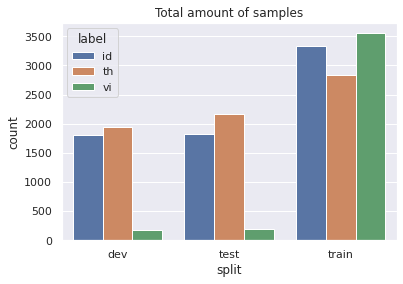

In [10]:
from lidbox.visualize import plot_sample_distribution

plot_sample_distribution(meta)

## Inspecting the audio

In [11]:
samples = (meta[meta["split"]=="train"]
           .groupby("label")
           .sample(n=2, random_state=np_rng.bit_generator))
samples

,client_id,path,sentence,label,split,target,duration,is_copy
id,,,,,,,,
common_voice_id_19392541,id_84d1fe116b609f7dbc2ae17da4c7125ddd414e44a1d...,/content/drive/MyDrive/lidbox-master/cv-corpus...,"Tiap minggu, ayahku menyimpan sebagian gajinya.",id,train,0,3.984,False
common_voice_id_19059501,id_8eb6a0f8aa447f1ea0fc2c8c57f6b88bb6027c5368e...,/content/drive/MyDrive/lidbox-master/cv-corpus...,Bagaimana cuaca kemarin?,id,train,0,3.936,False
common_voice_th_23656048,th_2e88003fba45e285e312a0993ec3ef1e119c0d50821...,/content/drive/MyDrive/lidbox-master/cv-corpus...,คุณเปรียบเทียบสองสิ่งนี้อย่างไร,th,train,1,4.104,False
common_voice_th_23665201,th_2e88003fba45e285e312a0993ec3ef1e119c0d50821...,/content/drive/MyDrive/lidbox-master/cv-corpus...,'อ้อ คราวนี้อะไรอีกละ?' ยูนิคอร์นร้องทักอย่างใ...,th,train,1,5.064,False
common_voice_vi_22402660_copy_2792,vi_e3e2b2e16592c532ea75a025969fa0ab1159b0ccdf9...,/content/drive/MyDrive/lidbox-master/cv-corpus...,mà mua về ngay cạnh nhà ông nội đã mất của thảo,vi,train,2,4.536,True
common_voice_vi_22402656_copy_376,vi_e3e2b2e16592c532ea75a025969fa0ab1159b0ccdf9...,/content/drive/MyDrive/lidbox-master/cv-corpus...,Hai chiếc dép kia gặp nhau tự bao giờ,vi,train,2,4.056,True


In [12]:
!pip install kaldiio
!pip install webrtcvad

  Created wheel for kaldiio: filename=kaldiio-2.17.2-cp36-none-any.whl size=24470 sha256=0a926933d43e407b78d007abcaca6c3904a5c7ed4c4806421becfcaf2386e9f6
  Stored in directory: /root/.cache/pip/wheels/66/9c/1c/6c9ebc779b47f576ffdfdb2bbf8958a67a14ffa41dbef808ca
Successfully built kaldiio
     |████████████████████████████████| 71kB 4.8MB/s 
  Created wheel for webrtcvad: filename=webrtcvad-2.0.10-cp36-cp36m-linux_x86_64.whl size=71429 sha256=8b04eb9185e546765ba11724b1bb3a7efba0a64835c4f9578195c358f145a870
  Stored in directory: /root/.cache/pip/wheels/44/2a/18/bd1aec41cac7c3051fe95d92a6ed446122ea31dc713c432fa1
Successfully built webrtcvad


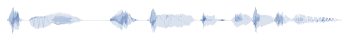

length: 2.62 sec
lang: id
sentence: Tiap minggu, ayahku menyimpan sebagian gajinya.


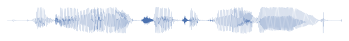

length: 1.8 sec
lang: id
sentence: Bagaimana cuaca kemarin?


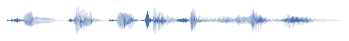

length: 2.5 sec
lang: th
sentence: คุณเปรียบเทียบสองสิ่งนี้อย่างไร


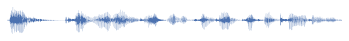

length: 3.29 sec
lang: th
sentence: 'อ้อ คราวนี้อะไรอีกละ?' ยูนิคอร์นร้องทักอย่างใคร่รู้


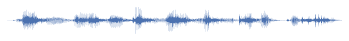

length: 2.64 sec
lang: vi
sentence: mà mua về ngay cạnh nhà ông nội đã mất của thảo


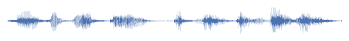

length: 2.29 sec
lang: vi
sentence: Hai chiếc dép kia gặp nhau tự bao giờ


In [22]:
from lidbox.features import audio
from lidbox.visualize import plot_signal
from IPython.display import display, Audio, HTML



def read_mp3(path):
    s, rate = audio.read_mp3(path)
    out_rate = 16000
    s = audio.pyfunc_resample(s, rate, out_rate)
    s = audio.peak_normalize(s[0], -3.0)
    s = audio.remove_silence(s, out_rate)
    return s, out_rate

def embed_audio(signal, rate):
    display(Audio(data=signal, rate=rate, embed=True))

def plot_separator():
    display(HTML(data="<hr style='border: 2px solid'>"))

    
for sentence, lang, clip_path in samples[["sentence", "label", "path"]].to_numpy():
    signal, rate = read_mp3(clip_path)
    signal = signal.numpy()
    plot_signal(signal)
    print("length: {} sec".format(signal.size / rate))
    print("lang:", lang)
    print("sentence:", sentence)
    embed_audio(signal, rate)
    plot_separator()

## Random filtering


original


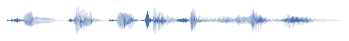

length: 2.5 sec
lang: th


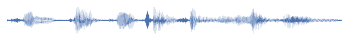

length: 2.5 sec
lang: th


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/constant_op.py:98: ComplexWarning: Casting complex values to real discards the imaginary part
  return ops.EagerTensor(value, ctx.device_name, dtype)


KeyboardInterrupt: ignored

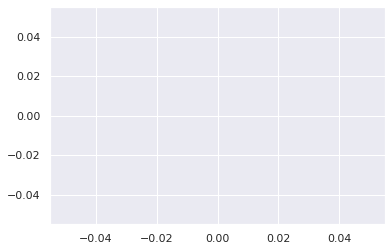

In [50]:
import scipy.signal


def random_filter(s, N=20):
    b = np_rng.normal(0, 5, N)
    return scipy.signal.lfilter(b, 1.0, s).astype(np.float32), b

def random_iirfilter(s, N=10):
  b = np_rng.normal(0,1,N)
  a = np_rng.normal(0,1,3)
  return scipy.signal.lfilter(b,a, s).astype(np.float32) , a, b

def random_noise(s):
  # target_noise_db = 0.01
  # # Convert to linear Watt units
  # target_noise_watts = 10 ** (target_noise_db / 10)
  # # Generate noise samples
  # mean_noise = 0
  # noise = np.random.normal(mean_noise, target_noise_watts, len(s))
  noise = np.random.normal(0, 0.01, len(s))
  return s + noise

def shift(signal): 
    s = np.zeros(len(signal)) 
    s[len(signal)//np.random.randint(4,128) - 1] = 1.0 
    return np.fft.fft(s) * signal

def display_signal(s, r, l):
    plot_signal(s)
    print("length: {} sec".format(s.size / r))
    print("lang:", l)
    embed_audio(s, r)
    plot_separator()

    
sentence, lang, path = samples[["sentence", "label", "path"]].to_numpy()[2]
signal, rate = read_mp3(path)
signal = audio.remove_silence(signal, rate).numpy()

print("original")
display_signal(signal, rate, lang)

np.set_printoptions(precision=1)

for _ in range(5):
    # s, b = random_filter(signal, 20)
    # print("filter:", b)
    # s = audio.peak_normalize(s, dBFS=-3.0).numpy()
    # display_signal(s, rate, lang)

    s = random_noise(signal)
    s = audio.peak_normalize(s, dBFS=-3.0).numpy()
    display_signal(s, rate, lang)

    s = shift(signal)
    s = audio.peak_normalize(s, dBFS=-3.0).numpy()
    display_signal(s, rate, lang)

    # s, a, b = random_iirfilter(signal)
    # print("filter:", a, b)
    # s = audio.peak_normalize(s, dBFS=-3.0).numpy()
    # display_signal(s, rate, lang)

## Random speed change

original


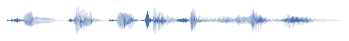

length: 2.5 sec
lang: th


speed ratio: 0.900


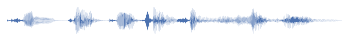

length: 2.77775 sec
lang: th


speed ratio: 0.950


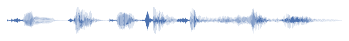

length: 2.6315625 sec
lang: th


speed ratio: 1.000


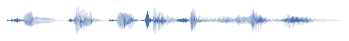

length: 2.5 sec
lang: th


speed ratio: 1.050


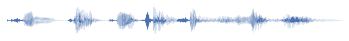

length: 2.3809375 sec
lang: th


speed ratio: 1.100


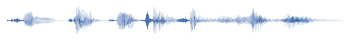

length: 2.2726875 sec
lang: th


In [20]:
def random_speed_change(s, r, lo=0.5, hi=1.5):
    ratio = np_rng.uniform(lo, hi)
    new_len = int(len(s) * r / (ratio * r))
    return scipy.signal.resample(s, new_len).astype(np.float32), ratio
    

print("original")
display_signal(signal, rate, lang)

for ratio in [0.9, 0.95, 1, 1.05, 1.1]:
    s, ratio = random_speed_change(signal, rate, lo=ratio, hi=ratio)
    print("speed ratio: {:.3f}".format(ratio))
    display_signal(s, rate, lang)

## Loading all data

In [52]:
from lidbox.features import audio, cmvn


TF_AUTOTUNE = tf.data.experimental.AUTOTUNE


def metadata_to_dataset_input(meta):   
    return {
        "id": tf.constant(meta.index, tf.string),
        "path": tf.constant(meta.path, tf.string),
        "label": tf.constant(meta.label, tf.string),
        "target": tf.constant(meta.target, tf.int32),
        "split": tf.constant(meta.split, tf.string),
        "is_copy": tf.constant(meta.is_copy, tf.bool),
    }


def read_mp3(x):
    s, r = audio.read_mp3(x["path"])
    out_rate = 16000
    s = audio.pyfunc_resample(s, r, out_rate)
    s = audio.peak_normalize(s[0], dBFS=-3.0)
    s = audio.remove_silence(s, out_rate)
    return dict(x, signal=s, sample_rate=out_rate)


def random_speed_change_wrapper(x):
    if not x["is_copy"]:
        return x
    s, _ = tf.numpy_function(
        random_speed_change,
        [x["signal"], x["sample_rate"]],
        [tf.float32, tf.float64],
        name="np_random_speed_change")
    return dict(x, signal=s)


def random_filter_wrapper(x):
    s, _ = tf.numpy_function(
        random_filter,
        [x["signal"]],
        [tf.float32, tf.float64],
        name="np_random_filter")
    s = tf.cast(s, tf.float32)
    s = audio.peak_normalize(s, dBFS=-3.0)
    return dict(x, signal=s)


def batch_extract_features(x):
    with tf.device("GPU"):
        signals, rates = x["signal"], x["sample_rate"]
        S = audio.spectrograms(signals, rates[0])
        S = audio.linear_to_mel(S, rates[0])
        S = tf.math.log(S + 1e-6)
        S = cmvn(S)
    return dict(x, logmelspec=S)


def signal_is_not_empty(x):
    return tf.size(x["signal"]) > 0


def pipeline_from_metadata(data, split):
    if split == "train":
        data = data.sample(frac=1)
    ds = (
        tf.data.Dataset.from_tensor_slices(metadata_to_dataset_input(data))
        .map(read_mp3, num_parallel_calls=TF_AUTOTUNE)
        .filter(signal_is_not_empty)
        # Try to keep 1000 signals prefetched in an in-memory buffer to reduce downstream latency
        .prefetch(1000)
        # Cache signals to a single file
        .cache(os.path.join(cachedir, "data", split))
        # In-memory buffer when reading from the cache
        .prefetch(1000))
    if split == "train":
        ds = (ds
              # Randomly change speed of all oversampled copies
              .map(random_speed_change_wrapper, num_parallel_calls=TF_AUTOTUNE)
              # Apply random filter for every training sample
              .map(random_filter_wrapper, num_parallel_calls=TF_AUTOTUNE))
    return (ds
        .batch(1)
        .map(batch_extract_features, num_parallel_calls=TF_AUTOTUNE)
        .unbatch())


cachedir = os.path.join(workdir, "cache")
# os.makedirs(os.path.join(cachedir, "data"))

split2ds = {
    split: pipeline_from_metadata(meta[meta["split"]==split], split)
    for split in meta.split.unique()
}

In [53]:
#@title

"""
Dataset steps are functions that can be applied on tf.data.Dataset instances using tf.data.Dataset.apply.
They are designed to do as much constant time pre-processing as possible when called, but do not evaluate the given dataset, except for some 'consume' and 'debug' steps.
See lidbox.data.pipelines.create_dataset for creating an end-to-end tf.data.Dataset pipeline from metadata.
"""
import collections
import io
import json
import logging
import os
import shutil
import time

logger = logging.getLogger(__name__)

import tensorflow as tf
TF_VERSION_MAJOR, TF_VERSION_MINOR = tuple(int(x) for x in tf.version.VERSION.split(".")[:2])

import lidbox
from lidbox import tf_utils as tf_utils
import lidbox.features as features
import lidbox.features.audio as audio_features


if lidbox.DEBUG:
    TF_AUTOTUNE = None
    tf.debugging.set_log_device_placement(True)
else:
    TF_AUTOTUNE = tf.data.experimental.AUTOTUNE

Step = collections.namedtuple("Step", ("key", "kwargs"))


def from_steps(steps):
    logger.info("Initializing and preparing tf.data.Dataset instance from %d steps:\n  %s", len(steps), "\n  ".join(s.key for s in steps))

    if steps[0].key != "initialize":
        logger.critical("When constructing a dataset, the first step must be 'initialize' but it was '%s'. The 'initialize' step is needed for first loading all metadata such as the utterance_id to wavpath mappings.", steps[0].key)
        return

    ds = initialize(**steps[0].kwargs)
    for step_num, step in enumerate(steps[1:], start=2):
        if step is None:
            logger.warning("Skipping no-op step with value None")
            continue
        step_fn = VALID_STEP_FUNCTIONS.get(step.key)
        if step_fn is None:
            logger.error("Skipping unknown step '%s'.", step.key)
            continue
        logger.info("Applying step number %d: '%s'.", step_num, step.key)
        ds = step_fn(ds, **step.kwargs)
        if not isinstance(ds, tf.data.Dataset):
            logger.critical("Failed to apply step '%s', it did not return a tf.data.Dataset instance but instead returned '%s'.", step.key, repr(ds))
            return

    logger.info("All %d steps completed, returning prepared tf.data.Dataset instance.", len(steps))

    return ds


def pre_initialize(meta, config, labels):
    index2id = list(enumerate(meta["id"]))
    modified = False
    if not config.get("allow_unknown_labels", False):
        logger.info("'allow_unknown_labels' is False, dropping all utterances which are not in the set of all labels.")
        all_labels = set(labels)
        label2invalid = collections.defaultdict(list)
        for i, u in index2id:
            l = meta["label"][i]
            if l not in all_labels:
                label2invalid[l].append(u)
        if label2invalid:
            logger.warning(
                    "%d invalid labels were found, with amount of utterances per label:\n  %s",
                    len(label2invalid),
                    "\n  ".join("{:12s}: {:12d}".format(l, len(u)) for l, u in label2invalid.items()))
            invalid_utts = {u for utts in label2invalid.values() for u in utts}
            logger.info("Dropping %d invalid utterances.", len(invalid_utts))
            index2id = [(i, u) for i, u in index2id if u not in invalid_utts]
            modified = True
        else:
            logger.info("All utterances have valid labels.")
    if config.get("shuffle_utterances", False):
        logger.info("'shuffle_utterances' is True, shuffling utterance id list.")
        from random import shuffle
        shuffle(index2id)
        modified = True
    if modified:
        logger.info("Utterance id list was modified, updating all metadata to ensure correct order.")
        meta = {k: [v[i] for i, _ in index2id] for k, v in meta.items()}
    return meta


def _feature_extraction_kwargs_to_args(config):
    valid_args = [
        "type",
        "spectrogram",
        "melspectrogram",
        "mfcc",
        "db_spectrogram",
        "sample_minmax_scaling",
        "window_normalization",
    ]
    return [config.get(arg, {}) for arg in valid_args]

def _element_shapes_dict(x):
    return {k: list(tf.shape(v).numpy()) for k, v in x.items()}

def _dict_to_logstring(d):
    return "\n  ".join("{}: {}".format(k, p) for k, p in d.items())

def _left_pad_lines(s, pad):
    return '\n'.join(pad * ' ' + line for line in s.splitlines())

def _get_device_or_default(config):
    tf_device = "/CPU"
    gpu_devices = tf.config.experimental.list_physical_devices("GPU")
    if "device" in config:
        tf_device = config["device"]
    elif gpu_devices:
        tf_device = "/GPU"
    return tf_device


def append_predictions(ds, predictions):
    """
    Add predictions to each element in ds.
    """
    def _append_predictions(x, p):
        return dict(x, prediction=p)
    predictions_ds = tf.data.Dataset.from_tensor_slices(predictions)
    return (tf.data.Dataset
              .zip((ds, predictions_ds))
              .map(_append_predictions, num_parallel_calls=TF_AUTOTUNE))


def apply_filters(ds, config):
    """
    Drop all elements from ds which do not satisfy all filter conditions given in config.
    """
    logger.info("Applying filters on every element in the dataset, keeping only elements which match the given config:\n  %s", _dict_to_logstring(config))

    filters = []

    if "equal" in config:
        key = config["equal"]["key"]
        value = config["equal"]["value"]
        fn = (lambda x, k=key, v=value:
                k not in x or tf.math.reduce_all(x[k] == v))
        filters.append((fn, key))

    if "min_signal_length_ms" in config:
        key = "signal"
        min_signal_length_sec = tf.constant(1e-3 * config["min_signal_length_ms"], tf.float32)
        tf.debugging.assert_scalar(min_signal_length_sec, message="min_signal_length_ms must be a scalar")
        fn = (lambda x, k=key, v=min_signal_length_sec:
                k not in x or tf.size(x[k]) >= tf.cast(tf.cast(x["sample_rate"], tf.float32) * v, tf.int32))
        filters.append((fn, "min_signal_length_sec"))

    if "min_shape" in config:
        key = config["min_shape"]["key"]
        min_shape = tf.constant(config["min_shape"]["shape"])
        fn = (lambda x, k=key, v=min_shape:
                k not in x or tf.math.reduce_all(tf.shape(x[k]) >= v))
        filters.append((fn, key))

    if filters:
        logger.info("Using %d different filters:\n  %s", len(filters), "\n  ".join(name for fn, name in filters))
    else:
        logger.warning("No filters defined, skipping filtering")
        return ds

    def all_ok(x):
        # This will be traced by tf autograph and converted into a graph, we cannot use python's builtin 'all' at the moment
        ok = True
        for fn, _ in filters:
            ok = ok and fn(x)
        return ok

    return ds.filter(all_ok)


def apply_vad(ds):
    """
    Assuming each element of ds have voice activity detection decisions, use the decisions to drop non-speech frames.
    """
    logger.info("Using previously computed voice activity decisions to drop signal frames marked as non-speech.")

    drop_keys_after_done = {"vad_frame_length_ms", "vad_is_speech"}

    def filter_signals_by_vad_decisions(x):
        vad_frame_length_sec = 1e-3 * tf.cast(x["vad_frame_length_ms"], tf.float32)
        vad_frame_length = tf.cast(tf.cast(x["sample_rate"], tf.float32) * vad_frame_length_sec, tf.int32)

        frames = tf.signal.frame(x["signal"], vad_frame_length, vad_frame_length, axis=0)
        voiced_signal = tf.reshape(frames[x["vad_is_speech"]], [-1])

        return {k: v for k, v in dict(x, signal=voiced_signal).items() if k not in drop_keys_after_done}

    return ds.map(filter_signals_by_vad_decisions, num_parallel_calls=TF_AUTOTUNE)


def as_supervised(ds):
    """
    Convert all element dictionaries to tuples of (inputs, targets) pairs that can be given to a Keras model as input.
    """
    logger.info("Converting all elements to tuple pairs (inputs, targets) and dropping all other values.")

    def _as_supervised(x):
        return x["input"], x["target"]

    return ds.map(_as_supervised, num_parallel_calls=TF_AUTOTUNE)


def augment_signals(ds, augment_configs):
    """
    Apply all augmentation methods specified in 'augment_config' and return a dataset where all elements are drawn randomly from the augmented and unaugmented datasets.
    """
    augmented_datasets = []
    for conf in augment_configs:
        aug_kwargs = {k: v for k, v in conf.items() if k not in {"type", "split"}}
        if conf["type"] == "random_resampling":
            augmented_datasets.append(augment_by_random_resampling(ds, **aug_kwargs))
        elif conf["type"] == "additive_noise":
            augmented_datasets.append(augment_by_additive_noise(ds, **aug_kwargs))
        else:
            logger.warning("Unknown signal augmentation type '%s', skipping", conf["type"])
    # Sample randomly from the unaugmented dataset and all augmented datasets
    return tf.data.experimental.sample_from_datasets([ds] + augmented_datasets)


#TODO what on earth is this mess
# this should be simplified, possibly by requiring some preprocessing on the metadata, e.g. as in
# random_signal_speed_change
def augment_by_additive_noise(ds, noise_datadir, snr_list, copy_noise_files_to_tmpdir=False):
    """
    Read all noise signals from $noise_datadir/id2path and create new signals by mixing noise to each element of ds.
    'snr_list' defines the noise labels, which is determined by $noise_datadir/id2label, and the SNR dB range from which the noise level in the resulting signal will be chosen randomly.
    E.g. to choose 3 random noise signals from categories "noise", "speech" and "music" with 3 different SNR dB (low, high) ranges:
        noise_datadir = "/my/path/musan"
        snr_list = [
            ("noise", 5, 15),
            ("speech", 15, 20),
            ("music", 10, 20)
        ]
    """
    logger.info("Augmenting dataset with additive noise from '%s'.", noise_datadir)
    if not os.path.isdir(noise_datadir):
        logger.error("Noise source dir '%s' does not exist.", noise_datadir)
        return

    id2type = dict(lidbox.iter_metadata_file(os.path.join(noise_datadir, "id2label"), 2))
    type2paths = collections.defaultdict(list)
    for noise_id, path in lidbox.iter_metadata_file(os.path.join(noise_datadir, "id2path"), 2):
        type2paths[id2type[noise_id]].append(path)
    del id2type

    if copy_noise_files_to_tmpdir:
        tmpdir = os.path.join(os.environ.get("TMPDIR", "/tmp"), "lidbox_noise_signals")
        logger.info("Copying all noise files to TMPDIR '%s'", tmpdir)
        for noise_type, paths in list(type2paths.items()):
            new_paths = []
            for src in paths:
                dst = os.path.join(tmpdir, noise_type, os.path.basename(src))
                logger.debug("%s -> %s", src, dst)
                os.makedirs(os.path.dirname(dst), exist_ok=True)
                shutil.copyfile(src, dst)
                new_paths.append(dst)
            type2paths[noise_type] = new_paths

    type2paths = {t: tf.constant(paths, tf.string) for t, paths in type2paths.items()}

    def _update_element_meta(new_id, mixed_signal, x):
        return dict(x, id=new_id, signal=mixed_signal)

    def _add_random_noise_and_flatten(x):
        """
        Using snr_list, choose len(snr_list) noise signals randomly and create new signal samples by mixing the chosen noise signals with x["signal"] using random SNR dB levels.
        """
        # Random noise path indexes and random snr levels
        rand_noise = [
                (noise_type,
                 tf.random.uniform([], 0, tf.size(type2paths[noise_type]), tf.int32),
                 tf.random.uniform([], snr_low, snr_high, tf.float32))
                for noise_type, snr_low, snr_high in snr_list]
        # Select random noise signals by drawn indexes and read contents from files
        rand_noise = [
                (audio_features.read_wav(type2paths[noise_type][rand_index]), snr)
                for noise_type, rand_index, snr in rand_noise]

        # Assert sample rates
        # TODO maybe add inline resampling of noise signals so they match the speech sr
        for (noise, sample_rate), snr in rand_noise:
            tf.debugging.assert_equal(sample_rate, x["sample_rate"], message="Invalid noise signals are being used, all noise signals must have same sample rate as speech signals that are being augmented")

        # Fix noise signal length to match x["signal"] by repeating the noise signal if it is too short and then slicing it
        rand_noise = [
                # How many multiples of `noise` fits in x["signal"]
                (tf.cast(tf.size(x["signal"]) / tf.size(noise), tf.int32), noise, snr)
                for (noise, _), snr in rand_noise]
        rand_noise = [
                # Repeat noise and slice
                (tf.tile(noise, [1 + noise_length_ratio])[:tf.size(x["signal"])], snr)
                for noise_length_ratio, noise, snr in rand_noise]

        # Mix x["signal"] and chosen noise signals
        mixed_signals = [audio_features.snr_mixer(x["signal"], noise, snr)[2] for noise, snr in rand_noise]
        # Create new utterance ids that contain the mixed noise type and SNR level
        new_ids = [
                tf.strings.join((
                        "augmented",
                        x["id"],
                        noise_type,
                        tf.strings.join(("snr", tf.strings.as_string(snr, precision=2)))),
                    separator="-")
                for (noise_type, _, _), (_, snr) in zip(snr_list, rand_noise)]

        # Create new elements from the mixed signals and return as dataset
        return (tf.data.Dataset
                  .zip((tf.data.Dataset.from_tensor_slices(new_ids),
                        tf.data.Dataset.from_tensor_slices(mixed_signals),
                        tf.data.Dataset.from_tensors(x).repeat(len(mixed_signals))))
                  .map(_update_element_meta))

    return ds.interleave(
                _add_random_noise_and_flatten,
                block_length=len(snr_list),
                num_parallel_calls=TF_AUTOTUNE)


def random_signal_speed_change(ds, min, max, flag=None):
    """
    Randomly change the speed of signals for elements that x[flag] == True or all elements if flag is None.
    Speed ratios are picked uniformly at random from the range [min, max].
    """
    logger.info("Applying random resampling to signals with a random speed ratio chosen uniformly at random from [%.3f, %.3f]", min, max)

    sample_rate_ratio_min = tf.constant(min, tf.float32)
    sample_rate_ratio_max = tf.constant(max, tf.float32)

    def _resample_copies_randomly(x):
        if flag and not x[flag]:
            return x

        random_ratio = tf.random.uniform([], sample_rate_ratio_min, sample_rate_ratio_max)
        in_rate = tf.cast(random_ratio * tf.cast(x["sample_rate"], tf.float32), tf.int32)
        out_rate = tf.cast(x["sample_rate"], tf.int32)

        resampled_signal, _ = audio_features.pyfunc_resample(x["signal"], in_rate, out_rate)
        return dict(x, signal=resampled_signal)

    return ds.map(_resample_copies_randomly, num_parallel_calls=TF_AUTOTUNE)


def random_signal_fir_filtering(ds, num_coefs=10, flag=None):
    """
    Apply FIR filters with random, normally distributed coefficients on signals for elements that x[flag] == True or all elements if flag is None.
    """
    logger.info("Applying random FIR filters of size %d on signals", num_coefs)

    num_coefs = tf.constant(num_coefs, tf.int32)

    def _apply_random_filter(x):
        if flag and not x[flag]:
            return x
        return dict(x, signal=audio_features.random_gaussian_fir_filter(x["signal"], num_coefs))

    return ds.map(_apply_random_filter, num_parallel_calls=TF_AUTOTUNE)


def cache(ds, directory=None, batch_size=1, cache_key=None):
    """
    Cache all elements of ds to disk or memory.
    """
    if directory is None:
        logger.warning("Caching dataset in batches of size %d into memory.", batch_size)
        cache_file = ''
    else:
        if cache_key is None:
            cache_key = str(int(time.time()))
        os.makedirs(directory, exist_ok=True)
        cache_file = os.path.join(directory, cache_key)
        if os.path.exists(cache_file + ".index"):
            logger.info("Loading elements from existing cache in directory '%s' with key '%s'.", directory, cache_key)
        else:
            logger.info("Caching dataset in batches of size %d to directory '%s' with key '%s'.", batch_size, directory, cache_key)

    return (ds.batch(batch_size)
              .prefetch(TF_AUTOTUNE)
              .cache(cache_file)
              .prefetch(TF_AUTOTUNE)
              .unbatch())


def validate_cache(dataframe, path, cache_key):
    """
    Validate any existing cache. Validation is based on saving the keys and shape of the given
    dataframe to JSON-format.
    """
    cache_file = f"{path}/{cache_key}_meta.json"
    if os.path.exists(cache_file):
        with open(cache_file, 'r', encoding='utf-8') as infile:
            existing_values = json.load(infile)
            new_keys = dataframe.columns.to_list()
            assert existing_values["keys"] == new_keys, \
                    f"Cache validation failed, old keys {existing_values['keys']} vs. new {new_keys}"
            assert existing_values["shape"] == list(dataframe.shape), \
                    f"Cache validation failed, old shape {existing_values['shape']} vs. new {dataframe.shape}"
            logger.info("Cache validation passed.")
    else:
        values = {"keys": dataframe.columns.to_list(), "shape": dataframe.shape}
        logger.info(f"Previous cache does not exist. Saving dataframe keys and shape to {cache_file} for validation.")
        with open(cache_file, 'w', encoding='utf-8') as outfile:
            json.dump(values, outfile, indent=2)


def compute_rms_vad(ds, strength, vad_frame_length_ms, min_non_speech_length_ms=0):
    """
    Compute root mean square based voice activity detection.
    """
    logger.info("Computing voice activity detection decisions by mean RMS values on %d ms long windows.\nMinimum length of continuous non-speech segment before it is marked as non-speech is %d ms.", vad_frame_length_ms, min_non_speech_length_ms)

    def _append_vad_decisions(x):
        vad_decisions = audio_features.framewise_rms_energy_vad_decisions(
                x["signal"],
                x["sample_rate"],
                vad_frame_length_ms,
                min_non_speech_ms=min_non_speech_length_ms,
                strength=strength)
        return dict(x, vad_is_speech=vad_decisions, vad_frame_length_ms=vad_frame_length_ms)

    return ds.map(_append_vad_decisions, num_parallel_calls=TF_AUTOTUNE)


def compute_webrtc_vad(ds, aggressiveness, vad_frame_length_ms, min_non_speech_length_ms):
    """
    Compute voice activity detection with WebRTC VAD.
    """
    vad_frame_length_sec = tf.constant(vad_frame_length_ms * 1e-3, tf.float32)
    min_non_speech_frames = tf.constant(min_non_speech_length_ms // vad_frame_length_ms, tf.int32)

    logger.info("Computing voice activity detection decisions with WebRTC VAD on %d ms long windows.\nMinimum length of continuous non-speech segment before it is marked as non-speech is %d ms.", vad_frame_length_ms, min_non_speech_length_ms)

    def _append_vad_decisions(x):
        signal, sample_rate = x["signal"], x["sample_rate"]
        vad_frame_length = tf.cast(tf.cast(sample_rate, tf.float32) * vad_frame_length_sec, tf.int32)
        frames = tf.signal.frame(signal, vad_frame_length, vad_frame_length, axis=0)
        _, pcm_data = audio_features.wav_to_pcm_data(signal, sample_rate)
        vad_decisions = tf.numpy_function(
                [signal, sample_rate, pcm_data, vad_frame_length, aggressiveness, min_non_speech_frames],
                args,
                tf.bool)
        vad_decisions = tf.reshape(vad_decisions, [tf.shape(frames)[0]])

        return dict(x, vad_is_speech=vad_decisions, vad_frame_length_ms=vad_frame_length_ms)

    return ds.map(_append_vad_decisions, num_parallel_calls=TF_AUTOTUNE)


def consume(ds, log_interval=-1):
    """
    Iterate over ds to exhaust the iterator and fully evaluate the preceding pipeline.
    """
    logger.info("Exhausting the dataset iterator by iterating over all elements, log_interval = %d", log_interval)

    speed = 0
    last_update = 0
    counter = time.perf_counter()

    def counter_step(i):
        nonlocal speed, last_update, counter
        stop = time.perf_counter()
        speed = max(0, (i - last_update) / (stop - counter))
        logger.info("%d done, %.3f elements per second.", i, speed)
        last_update = i
        counter = time.perf_counter()

    i = 0
    for i, element in ds.enumerate(start=1).as_numpy_iterator():
        if log_interval > -1 and i % log_interval == 0:
            counter_step(i)
    counter_step(i)

    return ds


def consume_to_tensorboard(ds, summary_dir, config, exist_ok=False):
    """
    Inspect the elements of ds by dumping them to TensorBoard summaries, e.g. features as spectrogram images and signals as wav audio.
    """
    if not exist_ok and os.path.isdir(summary_dir) and any(p.name.startswith("events") for p in os.scandir(summary_dir) if p.is_file()):
        logger.error("Skipping TensorBoard step since 'exist_ok' is False and directory '%s' already contains tf event files", summary_dir)
        return ds

    colors = tf_utils.matplotlib_colormap_to_tensor(config.get("colormap", "viridis"))
    image_size_multiplier = tf.constant(config.get("image_size_multiplier", 1), tf.float32)
    batch_size = tf.constant(config["batch_size"], tf.int64)
    max_outputs = tf.constant(config.get("max_elements_per_batch", batch_size), tf.int64)
    num_batches = tf.constant(config.get("num_batches", -1), tf.int64)

    @tf.function
    def _inspect_batches(batch_idx, batch):
        tf.debugging.assert_greater([tf.size(v) for v in batch.values()], 0, message="Empty batch given to tensorboard logger.")

        targets = batch["target"][:max_outputs]
        tf.summary.histogram("targets", targets, step=batch_idx)

        inputs = batch["input"][:max_outputs]
        tf.summary.histogram("inputs", inputs, step=batch_idx)
        images = tf_utils.tensors_to_rgb_images(inputs, colors, image_size_multiplier)
        tf.summary.image("inputs/img", images, step=batch_idx, max_outputs=max_outputs)

        if "signal" in batch:
            sample_rates = batch["sample_rate"][:max_outputs]
            tf.debugging.assert_equal(
                    sample_rates,
                    [sample_rates[0]],
                    message="Unable to add audio to tensorboard summary due to signals in the batch having different sample rates")
            tf.debugging.assert_greater(
                    tf.size(batch["signal"]),
                    0,
                    message="Unable to add audio to tensorboard summary due to empty signals in the batch")
            signals = tf.expand_dims(batch["signal"][:max_outputs], -1)
            tf.summary.audio("utterances",
                    signals,
                    sample_rates[0],
                    step=batch_idx,
                    encoding="wav",
                    max_outputs=max_outputs)

        enumerated_uttids = tf.strings.reduce_join(
                (tf.strings.as_string(tf.range(1, max_outputs + 1)), batch["id"][:max_outputs]),
                axis=0,
                separator=": ")
        tf.summary.text("utterance_ids", enumerated_uttids, step=batch_idx)

        if "transcript" in batch:
            tf.summary.text("transcripts", batch["transcript"][:max_outputs], step=batch_idx)

        return batch

    logger.info(
            "Writing %d first elements of %d batches, each of size %d, into Tensorboard summaries in '%s'",
            max_outputs.numpy(), num_batches.numpy(), batch_size.numpy(), summary_dir)

    writer = tf.summary.create_file_writer(summary_dir)
    with writer.as_default():
        _ = (ds.batch(batch_size, drop_remainder=True)
               .take(num_batches)
               .enumerate()
               .map(_inspect_batches, num_parallel_calls=TF_AUTOTUNE)
               .unbatch()
               .apply(consume))
    return ds


# TODO generalize and merge with create_signal_chunks
def create_input_chunks(ds, length, step):
    id_str_padding = 6

    def chunks_to_elements(chunk, chunk_num, x):
        chunk_num_str = tf.strings.as_string(chunk_num, width=id_str_padding, fill='0')
        chunk_id = tf.strings.join((x["id"], chunk_num_str), separator='-')
        return dict(x, id=chunk_id, input=chunk)

    def chunk_input_and_flatten(x):
        chunks = tf.signal.frame(x["input"], length, step, axis=0)
        num_chunks = tf.cast(tf.shape(chunks)[0], tf.int64)
        chunk_ds = tf.data.Dataset.from_tensor_slices(chunks)
        chunk_nums_ds = tf.data.Dataset.range(1, num_chunks + 1)
        repeat_x_ds = tf.data.Dataset.from_tensors(x).repeat(num_chunks)
        return (tf.data.Dataset
                  .zip((chunk_ds, chunk_nums_ds, repeat_x_ds))
                  .map(chunks_to_elements))

    return ds.interleave(chunk_input_and_flatten, num_parallel_calls=TF_AUTOTUNE)


def create_signal_chunks(ds, length_ms, step_ms, max_pad_ms=0, deterministic_output_order=True, max_num_chunks_per_signal=int(1e6), avg_num_chunks_from_signals=100):
    """
    Divide the signals of each element of ds into fixed length chunks and create new utterances from the created chunks.
    The metadata of each element is repeated into into each chunk, except for the utterance ids, which will be appended by the chunk number.
    """
    logger.info("Dividing every signal in the dataset into new signals by creating signal chunks of length %d ms and offset %d ms. Maximum amount of padding allowed in the last chunk is %d ms.", length_ms, step_ms, max_pad_ms)

    chunk_length_sec = tf.constant(1e-3 * length_ms, tf.float32)
    chunk_step_sec = tf.constant(1e-3 * step_ms, tf.float32)
    max_pad_sec = tf.constant(1e-3 * max_pad_ms, tf.float32)
    id_str_padding = tf.cast(tf.round(audio_features.log10(tf.cast(max_num_chunks_per_signal, tf.float32))), tf.int32)

    def chunks_to_elements(chunk, chunk_num, x):
        chunk_num_str = tf.strings.as_string(chunk_num, width=id_str_padding, fill='0')
        chunk_id = tf.strings.join((x["id"], chunk_num_str), separator='-')
        s = tf.reshape(chunk, [-1])
        out = dict(x, signal=s, id=chunk_id)
        if "duration" in x:
            out = dict(out, duration=tf.cast(tf.size(s) / x["sample_rate"], tf.float32))
        return out

    def chunk_signal_and_flatten(x):
        signal = x["signal"]
        sample_rate = tf.cast(x["sample_rate"], tf.float32)

        chunk_length = tf.cast(sample_rate * chunk_length_sec, tf.int32)
        chunk_step = tf.cast(sample_rate * chunk_step_sec, tf.int32)
        max_pad = tf.cast(sample_rate * max_pad_sec, tf.int32)
        num_full_chunks = tf.math.maximum(0, 1 + (tf.size(signal) - chunk_length) // chunk_step)
        tf.debugging.assert_less(num_full_chunks, max_num_chunks_per_signal, message="Too many chunks created from signal, cannot create unique utterance ids, raise the max_num_chunks_per_signal parameter")

        last_chunk_length = tf.size(signal) - num_full_chunks * chunk_step
        if last_chunk_length < chunk_length and chunk_length <= last_chunk_length + max_pad:
            signal = tf.pad(signal, [[0, chunk_length - last_chunk_length]])

        chunks = tf.signal.frame(signal, chunk_length, chunk_step, axis=0)
        num_chunks = tf.cast(tf.shape(chunks)[0], tf.int64)
        chunk_ds = tf.data.Dataset.from_tensor_slices(chunks)
        chunk_nums_ds = tf.data.Dataset.range(1, num_chunks + 1)
        repeat_x_ds = tf.data.Dataset.from_tensors(x).repeat(num_chunks)

        return (tf.data.Dataset
                  .zip((chunk_ds, chunk_nums_ds, repeat_x_ds))
                  .map(chunks_to_elements))

    interleave_kwargs = {
            "block_length": avg_num_chunks_from_signals,
            "num_parallel_calls": TF_AUTOTUNE,
            "deterministic": deterministic_output_order}
    if TF_VERSION_MAJOR == 2 and TF_VERSION_MINOR < 2:
        del interleave_kwargs["deterministic"]
        logger.warning("Deleted unsupported 'deterministic' kwarg from tf.data.Dataset.interleave call, TF version >= 2.2 is required.")

    return ds.interleave(chunk_signal_and_flatten, **interleave_kwargs)


def drop_empty(ds):
    """
    Drop all elements that contain an empty non-scalar value, e.g. signals of size 0 or spectrograms with 0 time frames.
    """
    non_scalar_keys = ("signal", "input")

    logger.info("Dropping every element which have an empty tensor at any of the non-scalar element keys:\n  %s", "\n  ".join(non_scalar_keys))

    def is_not_empty(x):
        empty = False
        for k in non_scalar_keys:
            if k in x and tf.size(x[k]) == 0:
                empty = True
        return not empty

    return ds.filter(is_not_empty)


def drop_invalid_wavs(ds):
    """
    Drop all samples that have a wav file with an invalid header.
    """
    logger.info("Dropping all elements that have a wav file with a corrupted header.")
    # The current wav check implementation has a lot of latency so we add flags in parallel and filter sequentially using the flags

    def _add_valid_header_flag(x):
        return dict(x, _wav_header_is_valid=audio_features.wav_header_is_valid(x["path"]))

    def _has_valid_header(x):
        return x["_wav_header_is_valid"]

    def _drop_flag(x):
        return {k: v for k, v in x.items() if k != "_wav_header_is_valid"}

    return (ds.map(_add_valid_header_flag, num_parallel_calls=TF_AUTOTUNE)
              .filter(_has_valid_header)
              .map(_drop_flag, num_parallel_calls=TF_AUTOTUNE))


def extract_embeddings(ds, config):
    """
    Use trained keras model instances to extract embeddings to key 'embedding' from key 'input' of each element in ds.
    """
    from lidbox.models.keras_utils import KerasWrapper

    extractors = [(KerasWrapper.from_config_as_embedding_extractor_fn(e), _get_device_or_default(e))
                  for e in config["extractors"]]
    # ConcreteFunctions will be pretty-formatted starting from TF 2.3
    # https://www.tensorflow.org/guide/concrete_function#changes_for_tensorflow_23
    logger.info("Using %d extractors:\n  %s",
            len(extractors),
            '\n  '.join("on device '{:s}':\n  {}".format(d, _left_pad_lines(str(e), 2)) for e, d in extractors))

    def _append_embeddings(x):
        embeddings = []
        for extractor_fn, device in extractors:
            with tf.device(device):
                embeddings.append(extractor_fn(x["input"]))
        return dict(x, embedding=tf.concat(embeddings, axis=1))

    batch_size = tf.constant(config.get("batch_size", 1), tf.int64)
    logger.info("Batching inputs with batch size %s, extracting embeddings in batches.", batch_size.numpy())
    ds = (ds.batch(batch_size)
            .prefetch(TF_AUTOTUNE)
            .map(_append_embeddings, num_parallel_calls=TF_AUTOTUNE))

    if not config.get("no_unbatch", False):
        logger.info("Unbatching after embedding extraction")
        ds = ds.unbatch()

    return ds


def extract_features(ds, config):
    """
    Extract features from signals of each element in ds and add them under 'input' key to each element.
    By default, feature extraction is requested to be placed on the first visible GPU, falling back on a CPU only if GPUs are not available.
    """
    feature_type = tf.constant(config["type"], tf.string)
    args = _feature_extraction_kwargs_to_args(config)
    tf_device = _get_device_or_default(config)

    logger.info("Extracting '%s' features on device '%s' with arguments:\n  %s", config["type"], tf_device, "\n  ".join(repr(a) for a in args[1:]))

    def _append_features(x):
        with tf.device(tf_device):
            features = tf_utils.extract_features(x["signal"], x["sample_rate"], *args)
        feature_types = tf.repeat(feature_type, tf.shape(features)[0])
        return dict(x, input=features, feature_type=feature_types)

    if "group_by_input_length" in config:
        max_batch_size = config["group_by_input_length"]["max_batch_size"]
        logger.info("Grouping signals by length, creating batches of max size %d from each group", max_batch_size)
        ds = group_by_axis_length(ds, "signal", max_batch_size, axis=0)
    else:
        batch_size = tf.constant(config.get("batch_size", 1), tf.int64)
        logger.info("Batching signals with batch size %s, extracting features in batches.", batch_size.numpy())
        ds = ds.batch(batch_size)

    return (ds.prefetch(TF_AUTOTUNE)
              .map(_append_features, num_parallel_calls=TF_AUTOTUNE)
              .unbatch())


def filter_keys_in_set(ds, keys):
    """
    For every element of ds, keep element keys only if they are in the set 'keys'.
    """
    logger.info("For each element in the dataset, keeping only values with keys: %s.", ', '.join(keys))

    def filter_keys(x):
        return {k: v for k, v in x.items() if k in keys}

    return ds.map(filter_keys, num_parallel_calls=TF_AUTOTUNE)


def group_by_axis_length(ds, element_key, max_batch_size, min_batch_size=0, axis=0):
    """
    Group elements such that every group is a batch where all tensors at key 'element_key' have the same length in a given dimension 'axis'.
    """
    logger.info("Creating batches of min size %d and max size %d where elements '%s' have same length along axis %d", min_batch_size, max_batch_size, element_key, axis)

    max_batch_size = tf.constant(max_batch_size, tf.int64)
    min_batch_size = tf.constant(min_batch_size, tf.int64)
    axis = tf.constant(axis, tf.int32)

    def get_seq_len(x):
        return tf.cast(tf.shape(x[element_key])[axis], tf.int64)

    def group_to_batch(key, group):
        return group.batch(max_batch_size)

    def has_min_batch_size(batch):
        return tf.shape(batch[element_key])[0] >= min_batch_size

    return ds.apply(tf.data.experimental.group_by_window(
        get_seq_len,
        group_to_batch,
        window_size=max_batch_size))


def initialize(labels, init_data):
    """
    Initialize a tf.data.Dataset instance for the pipeline.
    This should probably always be the first step.
    """
    ds = None
    init_data = {k: list(v) for k, v in init_data.items()}

    logger.info(
            "Initializing dataset from metadata:\n  %s",
            '\n  '.join("{}: {}".format(k, len(init_data[k])) for k in sorted(init_data.keys())))

    first_data = list(init_data.values())[0]
    if not all(len(first_data) == len(data) for data in init_data.values()):
        logger.error("Cannot initialize dataset from metadata dictionary that has values of different lengths")
        return

    ds = tf.data.Dataset.from_tensor_slices(init_data)
    label2int, _ = tf_utils.make_label2onehot(tf.constant(labels, tf.string))
    logger.info(
            "Generated label2target lookup table from indexes of array:\n  %s",
            '\n  '.join("{:s} {:d}".format(l, label2int.lookup(tf.constant(l, tf.string))) for l in labels))

    append_labels_as_targets = lambda x: dict(x, target=label2int.lookup(x["label"]))
    return ds.map(append_labels_as_targets, num_parallel_calls=TF_AUTOTUNE)


def load_audio(ds, num_prefetch=None):
    """
    Load signal from the 'path' key as WAV file for each element of ds.
    num_prefetch specifies how many signals to pre-load into main memory to reduce downstream latency.
    """
    if num_prefetch is None:
        num_prefetch = TF_AUTOTUNE

    logger.info("Reading audio files from the path of each element and appending the read signals and their sample rates to each element. Number of signals to prefetch: %d.", num_prefetch)

    def _append_signals(x):
        signal, sample_rate = audio_features.read_wav(x["path"])
        return dict(x, signal=signal, sample_rate=sample_rate)

    return (ds.map(_append_signals, num_parallel_calls=TF_AUTOTUNE)
              .prefetch(num_prefetch))


def normalize(ds, config):
    """
    Apply mean-variance normalization for all elements of ds for some key.
    Useful as a separate step e.g. if loading existing features from Kaldi archives.
    """
    logger.info("Applying normalization with config:\n  %s", _dict_to_logstring(config))

    key = config["key"]
    def _normalize(x):
        return dict(x, **{key: features.cmvn(x[key], **config.get("kwargs", {}))})

    return (ds.batch(config.get("batch_size", 1))
              .map(_normalize, num_parallel_calls=TF_AUTOTUNE)
              .unbatch())


def lambda_fn(ds, fn):
    """
    For debugging e2e pipelines, not useful otherwise.
    """
    logger.info("Applying function '%s' on dataset.", str(fn))
    return fn(ds)


def reduce_stats(ds, statistic, batch_size=1, **kwargs):
    """
    Reduce ds into a single statistic.
    This requires iterating over ds fully one time.
    """
    logger.info(
            "Iterating over whole dataset to compute statistic '%s' with batch size %d%s",
            statistic,
            batch_size,
            " using kwargs:\n  {}".format(_dict_to_logstring(kwargs)) if kwargs else '')

    batch_size = tf.constant(batch_size, tf.int64)
    if statistic == "num_elements":
        tmp_ds = ds.batch(batch_size, drop_remainder=True)
        num_batches = tmp_ds.reduce(tf.constant(0, tf.int64), lambda c, x: c + 1)
        num_batched = batch_size * num_batches
        num_remainder = ds.skip(num_batched).reduce(tf.zeros([], tf.int64), lambda c, x: c + 1)
        logger.info(
                "Num batches %d, batch_size %d, num batched elements %d, num remainder %d, total num elements: %d.",
                num_batches.numpy(), batch_size.numpy(), num_batched.numpy(), num_remainder.numpy(), (num_batched + num_remainder).numpy())

    elif statistic == "vad_ratio":
        # Peek VAD frame length from first element
        vad_frame_length_ms = list(ds.take(1).as_numpy_iterator())[0]["vad_frame_length_ms"]
        num, num_speech, num_not_speech, speech_ratio = tf_utils.compute_vad_decision_stats(ds, batch_size)
        logger.info(
                ("VAD frame statistics:\n  "
                 "num signals   %15d\n  "
                 "vad frame len %15d ms\n  "
                 "kept          %15d\n  "
                 "dropped       %15d\n  "
                 "total         %15d\n  "
                 "kept ratio    %15.3f"),
                num.numpy(),
                vad_frame_length_ms,
                num_speech.numpy(),
                num_not_speech.numpy(),
                (num_speech + num_not_speech).numpy(),
                speech_ratio.numpy())

    elif statistic == "size_counts":
        key = kwargs["key"]
        ndims = kwargs["ndims"]
        logger.info("Computing frequencies of sizes in all dimensions for key '%s' of every element of ds. Assuming ndims %d.", key, ndims)
        size_counts_by_axis = tf_utils.count_dim_sizes(ds.batch(batch_size), key, ndims)
        with io.StringIO() as sstream:
            for axis, size_counts in enumerate(size_counts_by_axis):
                print("\n  axis/dim {:d}:\n    [freq dim-size]".format(axis), file=sstream)
                for count in size_counts.numpy():
                    print("    {}".format(count), file=sstream)
            logger.info("%s", sstream.getvalue())

    elif statistic == "num_non_finite":
        key = kwargs["key"]
        axis = kwargs.get("axis")
        logger.info(
                "Computing frequency of non-finite tensors for key '%s' over axis %s in batches of %d.",
                key, str(axis), batch_size.numpy())
        count_non_finite = lambda t, axis=axis: tf.cast(not tf.math.reduce_any(tf.math.is_finite(t), axis=axis), tf.int64)
        accumulate_batches = lambda c, x: (c[0] + 1, c[1] + count_non_finite(x[key]))
        num_batches, num_non_finite = (ds
                .batch(batch_size, drop_remainder=True)
                .reduce((tf.zeros([], tf.int64), tf.zeros([batch_size], tf.int64)), accumulate_batches))
        num_batched = batch_size * num_batches
        num_remainder, num_non_finite_remainder = (ds
                .skip(num_batched)
                .batch(1)
                .reduce((tf.zeros([], tf.int64), tf.zeros([], tf.int64)), accumulate_batches))
        num_non_finite = tf.math.reduce_sum(num_non_finite) + num_non_finite_remainder
        logger.debug(
                "\n  num_batches %d\n  batch_size %d\n  num_batched %d\n  num_remainder %d\n  total num elements %d\n  num_non_finite %d\n  num_non_finite_remainder %d",
                *[t.numpy() for t in (num_batches, batch_size, num_batched, num_remainder, num_batched + num_remainder, num_non_finite, num_non_finite_remainder)])
        logger.info(
                "Dataset has %d tensors in total under key '%s' of which %d tensors have one or more non-finite values (NaN or inf).",
                (num_batched + num_remainder).numpy(), key, num_non_finite.numpy())

    elif statistic == "min_max_mean":
        key = kwargs["key"]
        logger.info(
                "Computing minimum, maximum and mean scalar values over all tensors under key '%s' in batches of %d.",
                key, batch_size.numpy())
        min, max, num, sum = tf_utils.reduce_min_max_num_sum(ds, key, batch_size)
        mean = tf.math.divide_no_nan(sum, tf.cast(num, tf.float64))
        logger.info(
                "\n  key '%s'\n  total num scalars %s\n  min %.6f\n  max %.6f\n  mean %.6f\n  sum %.6f",
                key, format(num.numpy(), ","), min.numpy(), max.numpy(), mean.numpy(), sum.numpy())

    else:
        logger.error("Unknown statistic type '%s', cannot compute stats for dataset.", statistic)

    return ds


def remap_keys(ds, new_keys):
    """
    Given a dictionary 'new_keys' of key-to-key mappings, update the keys of every element in ds with the new keys, if the key is in 'new_keys'.
    If some key maps to None, that key (and value) is dropped from each element that contains the key.
    """
    logger.info("Remapping keys of every element using config:\n  %s", _dict_to_logstring(new_keys))

    def remap_keys(x):
        return {new_keys.get(k, k): v for k, v in x.items() if new_keys.get(k, k) is not None}
    return ds.map(remap_keys, num_parallel_calls=TF_AUTOTUNE)


def repeat_too_short_signals(ds, min_length_ms):
    """
    For every element of ds, repeat each signal shorter than min_length_ms until it is equal to or longer than the given threshold.
    E.g.
        threshold equals 4 samples and x['signal'] length 3 < 4 is:
            [0, 1, 2]
        then new x['signal'] length 6 > 4 will be
            [0, 1, 2, 0, 1, 2]
    """
    logger.info("Repeating all signals until they are at least %d ms", min_length_ms)

    min_length_sec = tf.constant(1e-3 * min_length_ms, tf.float32)
    def _repeat_signal(x):
        repeat_ratio = tf.math.divide_no_nan(
                min_length_sec * tf.cast(x["sample_rate"], tf.float32),
                tf.cast(tf.size(x["signal"]), tf.float32))
        repeated_signal = tf.tile(x["signal"], [tf.cast(tf.math.ceil(repeat_ratio), tf.int32)])
        return dict(x, signal=repeated_signal)

    return ds.map(_repeat_signal, num_parallel_calls=TF_AUTOTUNE)


def show_all_elements(ds, shapes_only=True):
    """
    Iterate over ds printing shapes of every element.
    If shapes_only is False, print also summary of contents.
    """
    if shapes_only:
        log_print = lambda i, e: logger.info(
                "Element %d:\nshapes:\n  %s",
                i, _dict_to_logstring(_element_shapes_dict(e)))
    else:
        log_print = lambda i, e: logger.info(
                "Element %d:\nshapes:\n  %s\ncontents:\n  %s",
                i, _dict_to_logstring(_element_shapes_dict(e)), _dict_to_logstring(e))

    logger.info("Showing all elements.")
    i = 0
    for i, element in ds.enumerate(start=1).as_numpy_iterator():
        if not isinstance(element, dict):
            element = dict(enumerate(element))
        log_print(i, element)

    logger.info("All %d elements shown.", i)
    return ds


def shuffle(ds, buffer_size):
    logger.info("Shuffling dataset with buffer size %d", buffer_size)
    return ds.shuffle(buffer_size)


def load_kaldi_data(ds, shape):
    """
    Assuming ds has been initialized with kaldi_ark_key, then for each element of ds:
        - Load the array from the Kaldi archive as a float32 tensor
        - Set a statically known shape (use None for variable length dimensions)
        - Store the tensor under 'input', dropping kaldi_ark_key
    """
    logger.info("Loading Kaldi data from external archives using ark keys stored in every element under 'kaldi_ark_key' and reshaping the data to shape %s", repr(shape))

    def _load_ark(x):
        data = features.load_tensor_from_kaldi_archive(x["kaldi_ark_key"])
        data.set_shape(shape)
        ret = dict(x, input=data)
        del ret["kaldi_ark_key"]
        return ret

    return ds.map(_load_ark)


def unstable_reduce_features_mean_variance(ds, axis=0, key="input"):
    """
    Compute mean and variance over whole dataset using a naive summation algorithm.
    Becomes more unstable as the number of elements increase.

    https://en.wikipedia.org/wiki/Algorithms_for_calculating_variance#Two-pass_algorithm
    """
    def _feature_sums(x):
        return tf.math.reduce_sum(x, axis=axis, keepdims=True)

    first = next(ds.take(1).as_numpy_iterator())
    accumulator_shape = tf.shape(_feature_sums(first[key]))

    def _accumulate_count_and_sum(acc, x):
        return (acc[0] + tf.cast(tf.shape(x[key])[axis], tf.int64),
                acc[1] + _feature_sums(tf.cast(x[key], tf.float64)))

    num_frames, sums1 = ds.reduce(
            (tf.constant(0, tf.int64),
             tf.zeros(accumulator_shape, tf.float64)),
            _accumulate_count_and_sum)
    means = sums1 / tf.cast(num_frames, tf.float64)

    assert num_frames.numpy() > 1, "cannot compute variances on dataset that has {} frames, must be greater than 1".format(num_frames.numpy())

    def _accumulate_square_mean_diff_sum(acc, x):
        diff = tf.cast(x[key], tf.float64) - means
        return acc + _feature_sums(tf.math.square(diff))

    sums2 = ds.reduce(
            tf.zeros(accumulator_shape, tf.float64),
            _accumulate_square_mean_diff_sum)
    variances = sums2 / tf.cast(num_frames - 1, tf.float64)

    return num_frames, means, variances


def write_to_kaldi_files(ds, output_dir, element_key="input"):
    """
    For every element of ds, write the value at key element_key into utt2feat.scp and utt2feat.ark files to directory output_dir.
    """
    from kaldiio import WriteHelper

    os.makedirs(output_dir, exist_ok=True)
    output_path = os.path.join(output_dir, "utt2feat")
    write_specifier = "ark,scp:{0:s}.ark,{0:s}.scp".format(output_path)

    logger.info("Writing values of key '%s' for each element in the dataset to Kaldi ark and scp files with write specifier '%s'", element_key, write_specifier)

    with WriteHelper(write_specifier) as kaldi_writer:
        for x in ds.as_numpy_iterator():
            kaldi_writer(x["id"].decode("utf-8"), x[element_key])

    return ds


VALID_STEP_FUNCTIONS = {
    "append_predictions": append_predictions,
    "apply_filters": apply_filters,
    "apply_vad": apply_vad,
    "as_supervised": as_supervised,
    "augment_by_additive_noise": augment_by_additive_noise,
    "augment_signals": augment_signals,
    "cache": cache,
    "compute_rms_vad": compute_rms_vad,
    "compute_webrtc_vad": compute_webrtc_vad,
    "consume": consume,
    "consume_to_tensorboard": consume_to_tensorboard,
    "create_input_chunks": create_input_chunks,
    "create_signal_chunks": create_signal_chunks,
    "drop_empty": drop_empty,
    "drop_invalid_wavs": drop_invalid_wavs,
    "extract_embeddings": extract_embeddings,
    "extract_features": extract_features,
    "filter_keys_in_set": filter_keys_in_set,
    "group_by_axis_length": group_by_axis_length,
    "initialize": initialize,
    "lambda": lambda_fn,
    "load_audio": load_audio,
    "load_kaldi_data": load_kaldi_data,
    "normalize": normalize,
    "random_signal_fir_filtering": random_signal_fir_filtering,
    "random_signal_speed_change": random_signal_speed_change,
    "reduce_stats": reduce_stats,
    "remap_keys": remap_keys,
    "repeat_too_short_signals": repeat_too_short_signals,
    "show_all_elements": show_all_elements,
    "shuffle": shuffle,
    "unstable_reduce_features_mean_variance": unstable_reduce_features_mean_variance,
    "write_to_kaldi_files": write_to_kaldi_files,
}



# TODO random chunkers
#
# def make_random_frame_chunker_fn(len_config):
#     float_lengths = tf.linspace(
#         float(len_config["min"]),
#         float(len_config["max"]),
#         int(len_config["num_bins"]))
#     lengths = tf.unique(tf.cast(float_lengths, tf.int32))[0]
#     min_chunk_length = lengths[0]
#     tf.debugging.assert_greater(min_chunk_length, 1, message="Too short minimum chunk length")
#     min_overlap = tf.constant(float(len_config.get("min_overlap", 0)), tf.float32)
#     tf.debugging.assert_less(min_overlap, 1.0, message="Minimum overlap ratio of two adjacent random chunks must be less than 1.0")
#     @tf.function
#     def chunk_timedim_randomly(features):
#         num_total_frames = tf.shape(features)[0]
#         max_num_chunks = 1 + tf.math.maximum(0, num_total_frames - min_chunk_length)
#         rand_length_indexes = tf.random.uniform([max_num_chunks], 0, tf.size(lengths), dtype=tf.int32)
#         rand_chunk_lengths = tf.gather(lengths, rand_length_indexes)
#         rand_offset_ratios = tf.random.uniform([tf.size(rand_chunk_lengths)], 0.0, 1.0 - min_overlap, dtype=tf.float32)
#         offsets = tf.cast(rand_offset_ratios * tf.cast(rand_chunk_lengths, tf.float32), tf.int32)
#         offsets = tf.concat(([0], tf.math.maximum(1, offsets[:-1])), axis=0)
#         begin = tf.math.cumsum(offsets)
#         begin = tf.boolean_mask(begin, begin < num_total_frames)
#         end = begin + tf.boolean_mask(rand_chunk_lengths, begin < num_total_frames)
#         end = tf.math.minimum(num_total_frames, end)
#         # TODO gather is overkill here since we only want several slices
#         chunk_indices = tf.ragged.range(begin, end)
#         return tf.gather(features, chunk_indices)
#     return chunk_timedim_randomly

# TODO
# def get_random_chunk_loader(paths, meta, wav_config, verbosity=0):
#     raise NotImplementedError("todo, rewrite to return a function that supports tf.data.Dataset.interleave, like in get_chunk_loader")
#     chunk_config = wav_config["wav_to_random_chunks"]
#     sample_rate = wav_config["filter_sample_rate"]
#     lengths = tf.cast(
#         tf.linspace(
#             float(sample_rate * chunk_config["length"]["min"]),
#             float(sample_rate * chunk_config["length"]["max"]),
#             int(chunk_config["length"]["num_bins"]),
#         ),
#         tf.int32
#     )
#     def get_random_length():
#         rand_index = tf.random.uniform([], 0, tf.size(lengths), dtype=tf.int32)
#         rand_len = tf.gather(lengths, rand_index)
#         return rand_len
#     overlap_ratio = float(chunk_config["length"]["overlap_ratio"])
#     assert overlap_ratio < 1.0
#     min_chunk_length = int(sample_rate * chunk_config["min_chunk_length"])
#     assert min_chunk_length > 0, "invalid min chunk length"
#     def random_chunk_loader():
#         for p, *m in zip(paths, meta):
#             wav = audio_feat.read_wav(tf.constant(p, tf.string))
#             if "filter_sample_rate" in wav_config and wav.sample_rate != wav_config["filter_sample_rate"]:
#                 if verbosity:
#                     print("skipping file", p, ", it has a sample rate", wav.sample_rate, "but config has 'filter_sample_rate'", wav_config["filter_sample_rate"], file=sys.stderr)
#                 continue
#             begin = 0
#             rand_len = get_random_length()
#             chunk = wav.audio[begin:begin+rand_len]
#             while len(chunk) >= min_chunk_length:
#                 yield (audio_feat.Wav(chunk, wav.sample_rate), *m)
#                 begin += round((1.0 - overlap_ratio) * float(rand_len))
#                 rand_len = get_random_length()
#                 chunk = wav.audio[begin:begin+rand_len]
#     if verbosity:
#         tf_util.tf_print("Using random wav chunk loader, drawing lengths (in frames) from", lengths, "with", overlap_ratio, "overlap ratio and", min_chunk_length, "minimum chunk length")
#     return random_chunk_loader


## Exhaust iterators to collect all audio into binary files

**NOTE** that this creates 7.2 GiB of additional data on disk.

In [54]:
# import lidbox.steps as ds_steps
# from lidbox.data import steps as ds_steps

for split, ds in split2ds.items():
    print("filling", split, "cache")
    _ = consume(ds, log_interval=2000) 

filling test cache
2020-12-20 15:37:00.640 I __main__: Exhausting the dataset iterator by iterating over all elements, log_interval = 2000
2020-12-20 15:37:54.174 I __main__: 2000 done, 37.360 elements per second.
2020-12-20 15:38:03.226 I __main__: 4000 done, 221.092 elements per second.
2020-12-20 15:38:03.805 I __main__: 4178 done, 307.829 elements per second.
filling dev cache
2020-12-20 15:38:03.807 I __main__: Exhausting the dataset iterator by iterating over all elements, log_interval = 2000
2020-12-20 15:38:49.660 I __main__: 2000 done, 43.624 elements per second.
2020-12-20 15:38:55.924 I __main__: 3933 done, 308.642 elements per second.
filling train cache
2020-12-20 15:38:55.925 I __main__: Exhausting the dataset iterator by iterating over all elements, log_interval = 2000
2020-12-20 15:39:45.726 I __main__: 2000 done, 40.164 elements per second.
2020-12-20 15:40:11.974 I __main__: 4000 done, 76.209 elements per second.
2020-12-20 15:40:58.036 I __main__: 6000 done, 43.421 e

## Inspect dataset contents in TensorBoard

In [55]:
for split, ds in split2ds.items():
    _ = consume_to_tensorboard(
            ds.map(lambda x: dict(x, input=x["logmelspec"])),
            os.path.join(cachedir, "tensorboard", "data", split),
            {"batch_size": 1,
             "image_size_multiplier": 2,
             "num_batches": 100})

2020-12-20 15:54:28.869 I __main__: Writing 1 first elements of 100 batches, each of size 1, into Tensorboard summaries in '/data/cache/tensorboard/data/test'
Instructions for updating:
Use fn_output_signature instead


2020-12-20 15:54:30.704 W tensorflow: From /usr/local/lib/python3.6/dist-packages/tensorflow/python/util/deprecation.py:605: calling map_fn_v2 (from tensorflow.python.ops.map_fn) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Use fn_output_signature instead


2020-12-20 15:54:31.286 I __main__: Exhausting the dataset iterator by iterating over all elements, log_interval = -1
2020-12-20 15:54:34.048 I __main__: 100 done, 36.215 elements per second.
2020-12-20 15:54:34.066 I __main__: Writing 1 first elements of 100 batches, each of size 1, into Tensorboard summaries in '/data/cache/tensorboard/data/dev'
2020-12-20 15:54:34.499 I __main__: Exhausting the dataset iterator by iterating over all elements, log_interval = -1
2020-12-20 15:54:37.647 I __main__: 100 done, 31.783 elements per second.
2020-12-20 15:54:37.665 I __main__: Writing 1 first elements of 100 batches, each of size 1, into Tensorboard summaries in '/data/cache/tensorboard/data/train'
2020-12-20 15:54:38.093 I __main__: Exhausting the dataset iterator by iterating over all elements, log_interval = -1
2020-12-20 15:54:41.614 I __main__: 100 done, 28.410 elements per second.


## Train a supervised, neural network language classifier

In [56]:
import lidbox.models.xvector as xvector


def create_model(num_freq_bins, num_labels):
    model = xvector.create([None, num_freq_bins], num_labels, channel_dropout_rate=0.8)
    model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5))
    return model


model = create_model(
    num_freq_bins=40,
    num_labels=len(lang2target))
model.summary()

Model: "x-vector"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, None, 40)]        0         
_________________________________________________________________
channel_dropout (SpatialDrop (None, None, 40)          0         
_________________________________________________________________
frame1 (Conv1D)              (None, None, 512)         102912    
_________________________________________________________________
frame2 (Conv1D)              (None, None, 512)         786944    
_________________________________________________________________
frame3 (Conv1D)              (None, None, 512)         786944    
_________________________________________________________________
frame4 (Conv1D)              (None, None, 512)         262656    
_________________________________________________________________
frame5 (Conv1D)              (None, None, 1500)        769

In [57]:
def as_model_input(x):
    return x["logmelspec"], x["target"]


callbacks = [
    # Write scalar metrics and network weights to TensorBoard
    tf.keras.callbacks.TensorBoard(
        log_dir=os.path.join(cachedir, "tensorboard", model.name),
        update_freq="epoch",
        write_images=True,
        profile_batch=0,
    ),
    # Stop training if validation loss has not improved from the global minimum in 10 epochs
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
    ),
    # Write model weights to cache everytime we get a new global minimum loss value
    tf.keras.callbacks.ModelCheckpoint(
        os.path.join(cachedir, "model", model.name),
        monitor='val_loss',
        save_weights_only=True,
        save_best_only=True,
        verbose=1,
    ),
]

train_ds = split2ds["train"].map(as_model_input).shuffle(1000)
dev_ds = split2ds["dev"].map(as_model_input)

history = model.fit(
    train_ds.batch(1),
    validation_data=dev_ds.batch(1),
    callbacks=callbacks,
    verbose=1,
    epochs=100)

Epoch 1/100
9711/9711 [==============================] - 158s 15ms/step - loss: 1.0391 - val_loss: 1.2238

Epoch 00001: val_loss improved from inf to 1.22383, saving model to /data/cache/model/x-vector
Epoch 2/100
9711/9711 [==============================] - 134s 13ms/step - loss: 0.8715 - val_loss: 1.2723

Epoch 00002: val_loss did not improve from 1.22383
Epoch 3/100
9711/9711 [==============================] - 134s 13ms/step - loss: 0.7398 - val_loss: 1.3857

Epoch 00003: val_loss did not improve from 1.22383
Epoch 4/100
9711/9711 [==============================] - 133s 13ms/step - loss: 0.6461 - val_loss: 1.4704

Epoch 00004: val_loss did not improve from 1.22383
Epoch 5/100
9711/9711 [==============================] - 134s 13ms/step - loss: 0.5689 - val_loss: 1.2636

Epoch 00005: val_loss did not improve from 1.22383
Epoch 6/100
9711/9711 [==============================] - 132s 13ms/step - loss: 0.5196 - val_loss: 1.4805

Epoch 00006: val_loss did not improve from 1.22383
Epoch 7/

## Evaluate the classifier

In [58]:
"""
High-level utilities and wrappers on top of high-level APIs of other libraries.
"""
import numpy as np
import pandas as pd
import sklearn.metrics
import sklearn.preprocessing
import tensorflow as tf

import lidbox.metrics

TF_AUTOTUNE = tf.data.experimental.AUTOTUNE


def predictions_to_dataframe(ids, predictions):
    return (pd.DataFrame.from_dict({"id": ids, "prediction": predictions})
            .set_index("id", drop=True, verify_integrity=True)
            .sort_index())


def predict_with_model(model, ds, predict_fn=None):
    """
    Map callable model over all batches in ds, predicting values for each element at key 'input'.
    """
    if predict_fn is None:
        def predict_fn(x):
            with tf.device("GPU"):
                return x["id"], model(x["input"], training=False)

    ids = []
    predictions = []
    for id, pred in ds.map(predict_fn, num_parallel_calls=TF_AUTOTUNE).unbatch().as_numpy_iterator():
        ids.append(id.decode("utf-8"))
        predictions.append(pred)

    return predictions_to_dataframe(ids, predictions)


def chunk_parent_id(chunk_id):
    return chunk_id.rsplit('-', 1)[0]

def stack_and_average(v):
    return np.stack(v).mean(axis=0)

def merge_chunk_predictions(chunk_predictions, merge_rows_fn=None):
    if merge_rows_fn is None:
        merge_rows_fn = stack_and_average

    ids = []
    predictions = []
    for id, rows in chunk_predictions.groupby(chunk_parent_id):
        ids.append(id)
        predictions.append(merge_rows_fn(rows.prediction.values))

    return predictions_to_dataframe(ids, predictions)


def classification_report(true_sparse, pred_dense, label2target, dense2sparse_fn=None, num_cavg_thresholds=100):
    """
    Compute classification metrics on a given vector of true labels (sparse) and predicted scores (dense/onehot).
    """
    if dense2sparse_fn is None:
        dense2sparse_fn = lambda pred: pred.argmax(axis=1)
    pred_sparse = dense2sparse_fn(pred_dense)

    report = sklearn.metrics.classification_report(
                    true_sparse,
                    pred_sparse,
                    labels=list(range(len(label2target))),
                    target_names=label2target,
                    output_dict=True,
                    zero_division=0)

    cavg_thresholds = np.linspace(
            pred_dense.min(),
            pred_dense.max(),
            num_cavg_thresholds)
    cavg = lidbox.metrics.SparseAverageDetectionCost(len(label2target), cavg_thresholds)
    cavg.update_state(true_sparse, pred_dense)
    report["avg_detection_cost"] = float(cavg.result().numpy())

    def to_dense(target):
        v = np.zeros(len(label2target))
        v[target] = 1
        return v

    true_dense = np.stack([to_dense(t) for t in true_sparse])

    eer = np.zeros(len(label2target))
    for l, label in enumerate(label2target):
        # https://stackoverflow.com/a/46026962
        fpr, tpr, _ = sklearn.metrics.roc_curve(true_dense[:,l], pred_dense[:,l])
        fnr = 1 - tpr
        eer[l] = fpr[np.nanargmin(np.absolute(fnr - fpr))]

    report["avg_equal_error_rate"] = float(eer.mean())
    for label, i in label2target.items():
        report[label]["equal_error_rate"] = eer[i]

    report["confusion_matrix"] = sklearn.metrics.confusion_matrix(true_sparse, pred_sparse)

    # TODO convert to multi-level pandas.DataFrame by separating language metrics from summary metrics
    return report


def evaluate_testset_with_model(model, test_ds, test_meta, lang2target):
    """
    Utility for calling predict_with_model followed by classification_report.
    """
    utt2pred = predict_with_model(model, test_ds)
    test_meta = test_meta.join(utt2pred, how="outer")
    assert not test_meta.isna().any(axis=None), "Failed to join predictions from test_ds with given test_meta dataframe: set of utterance ids is not equal"

    true_sparse = test_meta.target.to_numpy(np.int32)
    pred_dense = np.stack(test_meta.prediction)

    return classification_report(true_sparse, pred_dense, lang2target)


def model2function(model):
    model_input = model.inputs[0]
    model_fn = tf.function(
            lambda x: model(x, training=False),
            input_signature=[tf.TensorSpec(model_input.shape, model_input.dtype)])
    return model_fn.get_concrete_function()


def standard_scaler(dataset, axis=0, key="input"):
    """
    Compute mean and variance on axis for every x[key] tensor for every element x in the given dataset.
    Return a standard scaler function that can be applied on tf.data.Datasets.
    """
    _, means, variances = lidbox.data.steps.unstable_reduce_features_mean_variance(
            dataset, axis=axis, key=key)
    stddevs = tf.math.sqrt(tf.math.maximum(1e-9, variances))

    def scale_dataset(ds):
        def _scale_element(x):
            scaled = tf.cast(x[key], tf.float64) - means
            scaled = tf.math.divide_no_nan(scaled, stddevs)
            return dict(x, **{key: tf.cast(scaled, x[key].dtype)})
        return ds.map(_scale_element, num_parallel_calls=TF_AUTOTUNE)

    return scale_dataset


avg_detection_cost: 0.319
avg_equal_error_rate: 0.294
accuracy: 0.632


,precision,recall,f1-score,support,equal_error_rate
id,0.674020,0.756326,0.712805,1818.000000,0.259746
th,0.789298,0.546549,0.645868,2159.000000,0.274393
vi,0.130638,0.417910,0.199052,201.000000,0.347247
mean,0.531318,0.573595,0.519241,1392.666667,0.293795


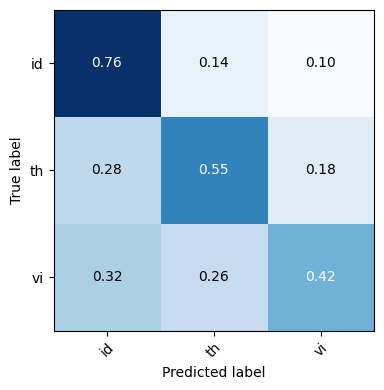

In [59]:
# from lidbox.util import evaluate_testset_with_model
from lidbox.visualize import draw_confusion_matrix


_ = model.load_weights(os.path.join(cachedir, "model", model.name))

report = evaluate_testset_with_model(
    model=model,
    test_ds=split2ds["test"].map(lambda x: dict(x, input=x["logmelspec"])).batch(1),
    test_meta=meta[meta["split"]=="test"],
    lang2target=lang2target)

for m in ("avg_detection_cost", "avg_equal_error_rate", "accuracy"):
    print("{}: {:.3f}".format(m, report[m]))
    
lang_metrics = pd.DataFrame.from_dict({k: v for k, v in report.items() if k in lang2target})
lang_metrics["mean"] = lang_metrics.mean(axis=1)
display(lang_metrics.T)

fig, ax = draw_confusion_matrix(report["confusion_matrix"], lang2target)

avg_detection_cost: 0.226
avg_equal_error_rate: 0.219
accuracy: 0.772


,precision,recall,f1-score,support,equal_error_rate
id,0.712950,0.838834,0.770786,1818.0,0.219083
th,0.840588,0.715609,0.773080,2159.0,0.219472
mean,0.776769,0.777221,0.771933,1988.5,0.219277


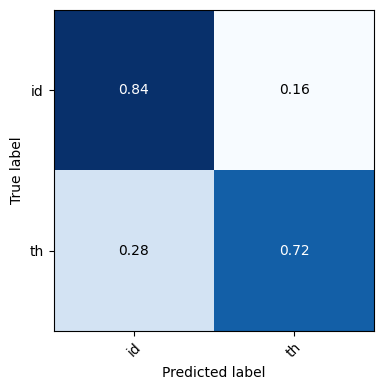

In [ ]:
# from lidbox.util import evaluate_testset_with_model
from lidbox.visualize import draw_confusion_matrix


_ = model.load_weights(os.path.join(cachedir, "model", model.name))

report = evaluate_testset_with_model(
    model=model,
    test_ds=split2ds["test"].map(lambda x: dict(x, input=x["logmelspec"])).batch(1),
    test_meta=meta[meta["split"]=="test"],
    lang2target=lang2target)

for m in ("avg_detection_cost", "avg_equal_error_rate", "accuracy"):
    print("{}: {:.3f}".format(m, report[m]))
    
lang_metrics = pd.DataFrame.from_dict({k: v for k, v in report.items() if k in lang2target})
lang_metrics["mean"] = lang_metrics.mean(axis=1)
display(lang_metrics.T)

fig, ax = draw_confusion_matrix(report["confusion_matrix"], lang2target)

## Conclusions

Comparing to our previous example with the same dataset of 4 different languages (`common-voice-small`), the $\text{C}_\text{avg}$ value improved from 0.112 to 0.091 and accuracy from 0.803 to 0.846.

Even though it is tempting to conclude that our augmentation approach was the cause of this improvement, we should probably perform hundreds of experiments with carefully chosen configuration settings to get a reliable answer if augmentation is useful or not.